In [1]:
import numpy as np 
import sympy as sym
from sympy.utilities.lambdify import lambdify, implemented_function


sin = sym.sin
cos = sym.cos

In [2]:
delta, omega, e1d, e1q = sym.symbols('delta omega e1d e1q')
i_d, i_q, v_d, v_q = sym.symbols('i_d i_q v_d v_q')
v_f, p_m = sym.symbols('v_f p_m')
X_d, X_q, X1d, X1q, X_l, R_a, T1d0, T1q0  = sym.symbols('X_d X_q X1d X1q X_l R_a T1d0 T1q0')
H, D = sym.symbols('H D')
V_t, theta_t, P_t, Q_t, V_inf, theta_inf = sym.symbols('V_t, theta_t, P_t, Q_t, V_inf, theta_inf')
B_t_inf, B_t0, G_t_inf, G_t0 = sym.symbols('B_t_inf, B_t0, G_t_inf, G_t0')
Omega_b, p_e = sym.symbols('Omega_b p_e')

## Initialization problem (backward)

In [3]:
N_x = 4
N_y = 7
ddelta = Omega_b * (omega - 1);
domega = 1/(2*H) * ( p_m - p_e - D * ( omega - 1)) ;
de1q   = 1/T1d0 * ( -e1q - (X_d - X1d ) * i_d + v_f);
de1d   = 1/T1q0 * ( -e1d + (X_q - X1q ) * i_q );

g1 = v_q + R_a * i_q - e1q + (X1d - X_l)*i_d;
g2 = v_d + R_a * i_d - e1d - (X1q - X_l)*i_q;
g3 = p_e - (v_q + R_a*i_q)*i_q - (v_d + R_a*i_d)*i_d ;
g4 = v_d - V_t * sin(delta - theta_t);
g5 = v_q - V_t * cos(delta - theta_t);
g6 = v_d * i_d + v_q * i_q - P_t; 
g7 = v_q * i_d - v_d * i_q - Q_t;
g8 =  V_t**2*(G_t_inf+G_t0) - V_t*V_inf*(G_t_inf * cos(theta_t - theta_inf) + B_t_inf * sin(theta_t - theta_inf)) - P_t  
g9 = -V_t**2*(B_t_inf+B_t0) - V_t*V_inf*(G_t_inf * sin(theta_t - theta_inf) - B_t_inf * cos(theta_t - theta_inf)) - Q_t  

In [4]:
x = sym.Matrix([delta,omega,e1q,e1d])
f = sym.Matrix([ddelta, domega, de1q, de1d])

y = sym.Matrix([i_d,i_q,p_e,v_d,v_q,p_m,v_f,theta_t,Q_t])
g = sym.Matrix([g1, g2, g3, g4, g5, g6, g7,g8,g9])

In [5]:
F_x = f.jacobian(x)
F_y = f.jacobian(y)
G_x = g.jacobian(x)
G_y = g.jacobian(y)

In [45]:
X_d = 1.81
X1d  = 0.3
T1d0  = 8.0
X_q  = 1.76
X1q  = 0.65
T1q0  = 1.0 
R_a  =  0.003 
X_l  = 0.15  
H  = 3.5   
Omega_b = 2*np.pi*60
Z_t_inf = 0.15+1.0/(1.0/0.5+1.0/0.93)

params = {
'X_d':  X_d,
'X1d':  X1d,
'T1d0': T1d0,
'X_q':  X_q,
'X1q':  X1q,
'T1q0': T1q0,
'R_a':  R_a,
'X_l': X_l,
'H':  H,
'D' : 0.1,
'Omega_b': Omega_b,
'B_t_inf':-1.0/Z_t_inf,
'B_t0':0.0, 
'G_t_inf':0.0,
'G_t0':0.0,
'V_inf':0.90081,
'theta_inf':0.0,   
}



In [46]:
u = sym.Matrix([P_t,V_t])

f_eval = lambdify((x,y,u), f.subs(params), "numpy")
g_eval = lambdify((x,y,u), g.subs(params), "numpy")
F_x_eval = lambdify((x,y,u), F_x.subs(params), "numpy")
F_y_eval = lambdify((x,y,u), F_y.subs(params), "numpy")
G_x_eval = lambdify((x,y,u), G_x.subs(params), "numpy")
G_y_eval = lambdify((x,y,u), G_y.subs(params), "numpy")

lam_sym = f.col_join(g)
xi_sym = x.col_join(y)
Lam_f = F_x.row_join(F_y)
Lam_g = G_x.row_join(G_y)
Lam_sym = Lam_f.col_join(Lam_g)


lam = lambdify((xi_sym,u), lam_sym.subs(params), "numpy")
Lam = lambdify((xi_sym,u), Lam_sym.subs(params), "numpy")



In [39]:
def nr(xi_0,u,lam,Lam):
    max_iter = 1000
    tol = 1.0e-8
    for it in range(max_iter):

        Dxi = np.linalg.solve(-Lam(xi_0,u),lam(xi_0,u))
        xi_1 = xi_0 + Dxi

        xi_0 = xi_1
        if np.linalg.norm(Dxi,np.infty)<tol: 
            #print(it)
            break
    return xi_0
#%timeit nr(x_0,lam,Lam)

In [49]:
xi_0 = np.ones((13,1))
u_val = np.array([[0.9],[1.0]])
xi_ini = nr(xi_0,u_val,lam,Lam)

## Simulation problem (forward)

In [116]:
N_x = 4
N_y = 9

x = sym.Matrix([delta,omega,e1q,e1d])
y = sym.Matrix([i_d,i_q,p_e,v_d,v_q,P_t,Q_t,V_t,theta_t])
u = sym.Matrix([p_m,v_f,D])

f = sym.Matrix([ddelta, domega, de1q, de1d])
g = sym.Matrix([g1, g2, g3, g4, g5,g6, g7, g8,g9])

F_x = f.jacobian(x)
F_y = f.jacobian(y)
G_x = g.jacobian(x)
G_y = g.jacobian(y)

In [117]:
xi_ini

array([[ 1.19873786],
       [ 1.        ],
       [ 0.90066861],
       [ 0.44818001],
       [ 0.91491593],
       [ 0.40376577],
       [ 0.90300029],
       [ 0.64731815],
       [ 0.76221993],
       [ 0.90300029],
       [ 2.28219166],
       [ 0.49467718],
       [ 0.43600224]])

In [154]:
params_run = {
'X_d':  X_d,
'X1d':  X1d,
'T1d0': T1d0,
'X_q':  X_q,
'X1q':  X1q,
'T1q0': T1q0,
'R_a':  R_a,
'X_l': X_l,
'H':  H,
'Omega_b': Omega_b,
'B_t_inf':-1.0/Z_t_inf,
'B_t0':0.0, 
'G_t_inf':0.0,
'G_t0':0.0,
'V_inf':0.90081,
'theta_inf':0.0,  
}

f_eval = lambdify((x,y,u), f.subs(params_run), "numpy")
g_eval = lambdify((x,y,u), g.subs(params_run), "numpy")
F_x_eval = lambdify((x,y,u), F_x.subs(params_run), "numpy")
F_y_eval = lambdify((x,y,u), F_y.subs(params_run), "numpy")
G_x_eval = lambdify((x,y,u), G_x.subs(params_run), "numpy")
G_y_eval = lambdify((x,y,u), G_y.subs(params_run), "numpy")

p_eval = lambdify((x,y,u),v_d * i_d + v_q * i_q, "numpy")
q_eval = lambdify((x,y,u), v_q * i_d - v_d * i_q , "numpy")
V_eval = lambdify((x,y,u),y[-2], "numpy")

lam_sym = f.col_join(g)
xi_sym = x.col_join(y)
Lam_f = F_x.row_join(F_y)
Lam_g = G_x.row_join(G_y)
Lam_sym = Lam_f.col_join(Lam_g)


lam = lambdify((xi_sym,u), lam_sym.subs(params_run), "numpy")
Lam = lambdify((xi_sym,u), Lam_sym.subs(params_run), "numpy")


In [146]:
def nr(xi_0,u,lam,Lam):
    max_iter = 100
    tol = 1.0e-8
    for it in range(max_iter):

        Dxi = np.linalg.solve(-Lam(xi_0,u),lam(xi_0,u))
        xi_1 = xi_0 + Dxi

        xi_0 = xi_1
        if np.linalg.norm(Dxi,np.infty)<tol: 
            #print(it)
            break
        if it==max_iter-1: 
            print('No convergence after', it)
            break
    return xi_0

xi_0 = np.ones((13,1))
xi_0[0] = 0
xi_0[-1] = 0
u_val = np.array([xi_ini[9],xi_ini[10],0.1])
xi_0 = nr(xi_0,u_val,lam,Lam)
print(xi_0)

[[ 1.19873786]
 [ 1.        ]
 [ 0.90066861]
 [ 0.44818001]
 [ 0.91491593]
 [ 0.40376577]
 [ 0.90300029]
 [ 0.64731815]
 [ 0.76221993]
 [ 0.9       ]
 [ 0.43600224]
 [ 1.        ]
 [ 0.49467718]]


In [155]:
def autos(p_m,v_f,D,xi_0):
    
    u_val = np.array([[p_m], [v_f], [D]])
    xi_run = nr(xi_0,u_val,lam,Lam)

    lam(xi_run, u_val)

    x_val = xi_run[0:N_x]
    y_val = xi_run[N_x:(N_x+N_y)]

    F_x_val = F_x_eval(x_val,y_val,u_val) 
    F_y_val = F_y_eval(x_val,y_val,u_val) 
    G_x_val = G_x_eval(x_val,y_val,u_val) 
    G_y_val = G_y_eval(x_val,y_val,u_val) 

    p_val = p_eval(x_val,y_val,u_val) 
    q_val = q_eval(x_val,y_val,u_val) 
    V_val = V_eval(x_val,y_val,u_val) 
    
    A =  F_x_val - F_y_val @ np.linalg.inv(G_y_val) @ G_x_val
    lamb, Phi = np.linalg.eig(A)
    return lamb, p_val, q_val,V_val

autos(xi_ini[9],xi_ini[10],0.1,xi_0)

(array([-0.19910064+8.04330863j, -0.19910064-8.04330863j,
        -2.05382649+0.j        , -0.12740967+0.j        ]),
 0.89999999999999991,
 0.43600223870683052,
 1.0)

In [156]:
from ipywidgets import interact, interactive, widgets
from IPython.display import display
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rc('animation', html='html5')
%matplotlib notebook 


<IPython.core.display.Javascript object>


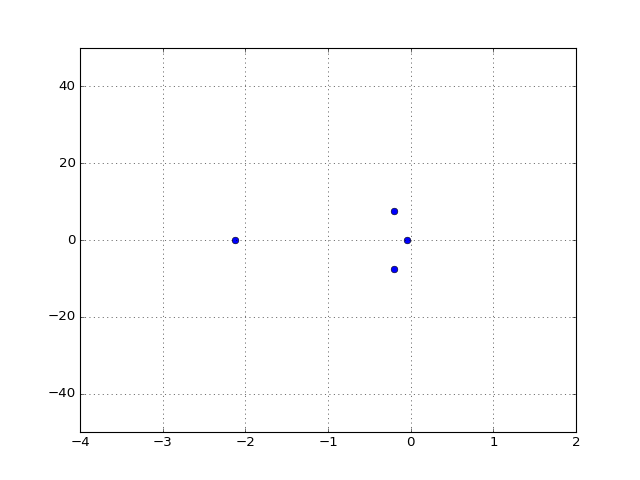

In [159]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_animated(True)
plt.xlim(-4, 2)
plt.ylim(-50, 50)
plt.grid(True)

poles = ax.plot([], 'o') 
#display(fig)


def update(p_m,v_f,D):
    lamb, p_val, q_val, V_val = autos(p_m,v_f,D,xi_0)
    poles[0].set_xdata(lamb.real)
    poles[0].set_ydata(lamb.imag)
    
    print('P   = {:2.2f}'.format(p_val))
    print('Q   = {:2.2f}'.format(q_val))
    print('V_t = {:2.2f}'.format(V_val))



sld_p_m = widgets.FloatSlider(min=0,max=1.2,step=0.01,value=xi_ini[9])
sld_v_f = widgets.FloatSlider(min=xi_ini[10]*0.5,max=xi_ini[10]*1.5,step=0.01,value=xi_ini[10])
sld_D = widgets.FloatSlider(min=0.0,max=5.0,step=0.01,value=0.1)
interaction = interactive(update,p_m=sld_p_m,v_f=sld_v_f,D=sld_D,continuous_update=False)    

In [160]:
display(interaction)

P   = 0.90
Q   = 0.25
V_t = 0.90


In [32]:
F_x.subs(params_run)

Matrix([
[0,     376.991118430775,      0,    0],
[0, -0.142857142857143*D,      0,    0],
[0,                    0, -0.125,    0],
[0,                    0,      0, -1.0]])

In [33]:
poles[0].set_xdata(2.0)

In [21]:
lamb = autos(1.0,0.0)

TypeError: autos() missing 2 required positional arguments: 'D' and 'xi_0'

In [ ]:
lamb

In [ ]:
poles[0].set_xdata(lamb.real)